<a href="https://colab.research.google.com/github/LorenzoLamberti94/APAI2021/blob/main/Solution_LAB1_APAI_DNN_Definition_%26_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LAB1 APAI: DNN Definition & Training**

Credits: Francesco Conti,  Lorenzo Lamberti, Alessio Burrello, Nazareno Bruschi, Davide Nadalini, Alberto Dequino.

(University of Bologna)

Output Lab session:

*   pytorch definition of a NN model
*   Code for training a neural network on MNIST
*   Code for testing a neural network on MNIST dataset
*   Bonus: Function to calculate MAC and kB of the Neural model defined





## **In this Hands-on session:**

A first-time user of Pytorch framework will learn how to define, train, and test a neural network over the MNIST dataset.

Let us start by installing dependencies...

In [ ]:
#@title Install dependencies { form-width: "20%" }

# these ones should already be available
!pip install numpy
!pip install tqdm
!pip install pillow

!pip install torch
!pip install torchvision

!pip install thop
!pip install matplotlib
!pip install sklearn
!pip install torchsummary

# !pip install jupyter
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension



In [ ]:
#@title Imports { form-width: "25%" }

#basic
import os
from os.path import join
import numpy as np
from tqdm import tqdm

#plotting
import matplotlib.pyplot as plt

#torch
import torch; print('\nPyTorch version in use:', torch.__version__, '\ncuda avail: ', torch.cuda.is_available())
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#torchvision
from torchvision import datasets, transforms
import torchvision

# others
from copy import deepcopy


#KEEP ?
import torchvision.models as models
from torchvision import transforms
import time
from tqdm.autonotebook import tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect


In [ ]:
#@title Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: %s' % device)

### Creating Model, Optimizer and Loss

The first real step is to define the network topology. 

* Use `torch.nn.Module`,
* Instantiate a separate `torch.nn.Module` for each node in your topology; This is mandatory for parametric modules (e.g., `torch.nn.Conv2d`)



# PLACEHOLDER IMAGE FOR NETWORK TOPOLOGY DEFINITION

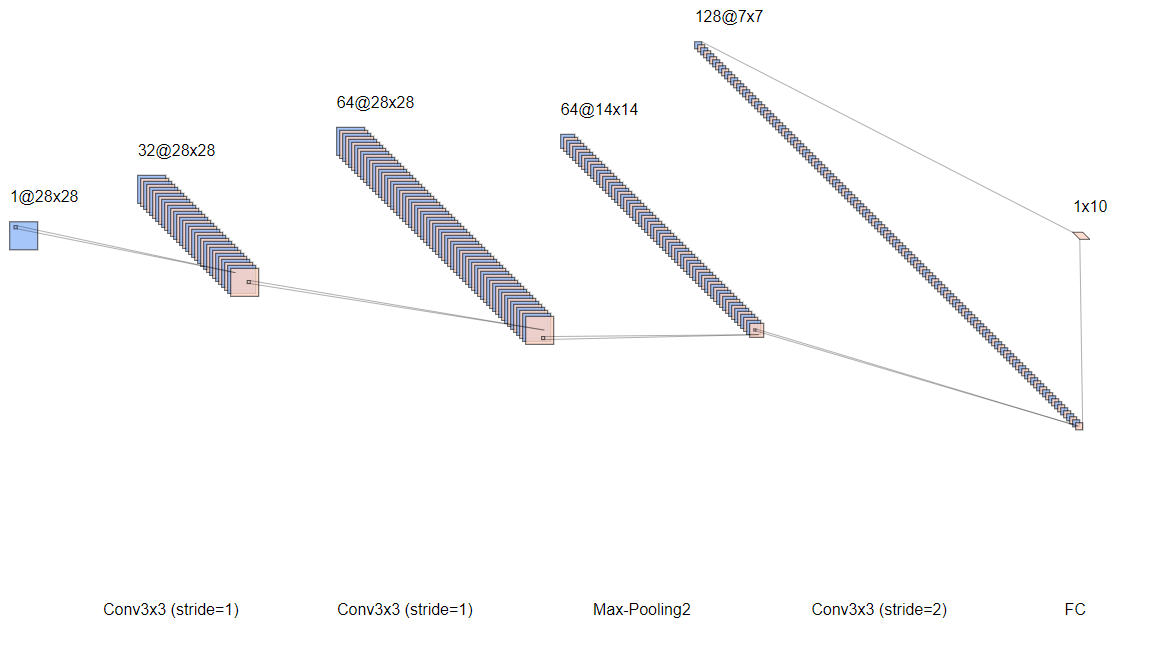

In [ ]:
class ConvBnRelu(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(ConvBnRelu, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1, bias=False, padding_mode='zeros')
        self.bn1 = nn.BatchNorm2d(num_features=out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        return x

class CNN(nn.Module):
    def __init__(self, n_classes=10, depth_mult=1.):
        super(CNN, self).__init__()
        # first_conv_channels=int(32*depth_mult)
        self.ConvBnRelu1 = ConvBnRelu(1, 32,  stride=1) # conv3x3: ch_in=1, ch_out=32, in=28x28, out=28x28/2
        self.ConvBnRelu2 = ConvBnRelu(32, 64,  stride=1) # conv3x3: ch_in=1, ch_out=32, in=28x28, out=28x28/2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, return_indices=False, ceil_mode=False) # MaxPool2: in=14x14, out=14x14/2
        self.ConvBnRelu3 = ConvBnRelu(64, 128, stride=2) # conv3x3: ch_in=32, ch_out=64, in=7x7, out=7x7
        self.dropout = nn.Dropout(p=0.5, inplace=False)
        fc_in_size = 7*7*128
        self.fc = nn.Linear(fc_in_size, n_classes, bias=False)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.ConvBnRelu1(x)
        x = self.ConvBnRelu2(x)
        x = self.pool(x)
        x = self.ConvBnRelu3(x)
        x = self.dropout(x)
        x = x.flatten(1)
        x = self.fc(x)
        output = self.softmax(x)
        return output

net = CNN().to(device)


### Test defined network, and verify layers




In [ ]:
#@title Dummy input  { form-width: "70%" }
# input_size = (img_ch,img_width, img_height)
input_size = (1, 28, 28)  #@param
input = torch.randn((1,) + input_size).to(device)#add one extra field to input size for batch_n


Print output tensor size and the CNN network topology defined:

In [ ]:
output = net(input)
print('Output shape:', output.shape)
print('Network Topology:\n',net)

## Count network's parameters and MAC operations
Let's define a couple of useful functions to measure the model's MAC operations and number of parameters.

In [ ]:
def network_size_and_mac(net, input_size, verbose=False):
    from thop import profile
    input_size = (1,) + input_size #add one extra field to input size for batch_n
    if verbose: print('input_size is now:', input_size)
    input = torch.randn(input_size).to(device) # initialize a random tensor
    macs, params = profile(net, inputs=(input, ), verbose=verbose) #toggle verbose to True to debug errors
    print("Network's \tn°params: %.3fk \tMAC: %.3fM\n" % (params/1e3, macs/1e6))

def print_summary(net, input_size):
    from torchsummary import summary
    summary(net, input_size=input_size)

network_size_and_mac(deepcopy(net), input_size) #use deepcopy to avoid graph modifications by hese function calls
print_summary(deepcopy(net), input_size) #use deepcopy to avoid graph modifications by hese function calls

**Torchsummary insights**

A nice way to print a summary of the Network topology is torchsummary, but this tool is not providing a MAC count.

**Note**: This tool calculates the Model Size as (number_of_parameters*4).
This because each parameter needs 4 Bytes (32bit) to be represented in float32 format.

## Average Meter class (not used right now)

In [ ]:
# convenience class to keep track of averages
class AverageMeter(object):
    """
    Computes and stores the average and current value
    Copied from: https://github.com/pytorch/examples/blob/master/imagenet/main.py
    """
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt # format. example ':6.2f'
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)




### Dataset & Network

In this notebook we'll a custom CNN on the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), which is a set of 28x28 grayscale images of clothes.
This dataset is provided by the [Torchvision package](https://pytorch.org/docs/stable/torchvision/index.html).

Before diving in, let's look at the Fashion MNIST dataset. The dataset has 6k training images and 1k validation images. It has a total of 10 classes, each represented by an integer index. The following cell creates a mapping from these indices to their corresponding human-readable strings, then downloads the Fashion MNIST training dataset from Torchvision. It may take a minute to run.

Torchvision provides easy access to many datasets, including COCO, CIFAR, and Cityscapes. See its documentation for a complete list. 

The dataset is stored on the Colab VM in the `/data/fashionmnist` directory.

*You can explore dataset images by changing the index below:*

In [ ]:
class_map = {
0 : "t-shirt",
1 : "trouser",
2 : "pullover",
3 : "dress",
4 : "coat",
5 : "sandal",
6 : "shirt",
7 : "sneaker",
8 : "bag",
9 : "ankle boot"
}

# Downloads the Fashion MNIST dataset using Torchvision
fashion_mnist_dataset = datasets.FashionMNIST(
    os.path.join("./data/fashionmnist"),
    train=True,
    download=True)

img_index = 0 #@param {type:"integer"}

tup = fashion_mnist_dataset[img_index] # tup = (image, label)
display(tup[0].resize((224, 224)))
print(class_map[tup[1]])

### Data loaders for Fashion MNIST



The code below first sets up transform using `torhvision transfroms` for converting images to pytorch tensors and normalizing the images.

Next, We use `torchvision datasets` for dowloading the fashion mnist dataset and applying transforms which we defined above.

* `train_dataset` contains the training data.
* `valid_dataset` contains the validation data

Next, We use `pytorch dataloader` for making dataloader from the train and validation sets.

In [ ]:
def get_data_loaders(train_batch_size=128, val_batch_size=128, verbose=False):
    #define data transformations
    fashion_mnist = torchvision.datasets.FashionMNIST(download=True, train=True, root="./data/fashionmnist").train_data.float()
    data_transform = transforms.Compose([transforms.ToTensor(), 
                                         transforms.Normalize((fashion_mnist.mean()/255,), (fashion_mnist.std()/255,))])
    
    # Load train/valid datasets
    train_dataset = torchvision.datasets.FashionMNIST(download=False, root="./data/fashionmnist", transform=data_transform, train=True)
    valid_dataset = torchvision.datasets.FashionMNIST(download=False, root="./data/fashionmnist", transform=data_transform, train=False)

    # define dataloaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=train_batch_size, 
        shuffle=True)
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, 
        batch_size=val_batch_size, 
        shuffle=False)

    # count how many images we have in each set
    train_dataset_size = len(train_dataset)
    valid_dataset_size = len(valid_dataset)
    if verbose: print('Dataset size:\nTraining images %d,\nValidation images %d' % (train_dataset_size, valid_dataset_size))
    
    return train_loader, valid_loader

train_loader, val_loader = get_data_loaders( verbose=True)


### Metric calculation

In [ ]:
def calculate_metric(metric_fn, true_y, pred_y):
    if "average" in inspect.getfullargspec(metric_fn).args:
        return metric_fn(true_y, pred_y, average="macro")
    else:
        return metric_fn(true_y, pred_y)
    

In [ ]:
def calculate_accuracy(best_guess, targets):
    num_correct += torch.eq(targets, best_guesses).sum().item()
    total_guesses += batch_size
    correct_percentage = num_correct/total_guesses
    return correct_percentage

### Testing Function
Before training we want to verify our data->network pipeline and set a baseline level of performance. The following cell defines a function, `validate,` that runs a network on a dataset and shows the percentage of the dataset that was correctly classified.

In [ ]:
def validate(net, val_loader, loss_function, accuracy_score):
    val_losses = []
    val_accuracy = []
    
    # set net to evaluating (testing)
    net.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader):
            inputs, labels = data[0].to(device), data[1].to(device)

            # net forward
            outputs = net(inputs) # this get's the prediction from the network

            # calculate loss
            loss = loss_function(outputs, labels)
            val_losses.append(loss) # append current average training loss to a buffer variable, for plotting learning curve

            # calculate validation accuracy
            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
            val_accuracy.append(calculate_metric(accuracy_score, labels.cpu(), predicted_classes.cpu())) 
    
    average_val_loss = sum(val_losses)/(batch_idx+1)
    return val_accuracy, average_val_loss
    

You should see the untrained network guess about 10% of the dataset correctly, since it's randomly guessing and there are 10 classes.

In [ ]:
loss_function = nn.CrossEntropyLoss() # cross entropy works well for multi-class problems

val_accuracy, average_val_loss = validate(net, get_data_loaders()[1], loss_function, accuracy_score)
print('Accuracy: %0.2f'% (sum(val_accuracy)/len(val_accuracy)))

## **Training Loop**

Basic training in PyTorch:

- enumerates a dataset in batches
- runs the network on each batch
- evaluates the network's performance using a loss function
- calls `backward()` to propagate gradients through the network
- uses an optimizer to `step()` and apply the gradients to the network's weights

In this case we'll use the [CrossEntropyLoss](https://pytorch.org/docs/master/nn.html#torch.nn.CrossEntropyLoss) since we have a classification problem.
We'll also use the [Adam](https://pytorch.org/docs/master/optim.html#torch.optim.Adam) optimizer since it's a popular optimizer.

We'll only train for a few epoch for timeliness. The following cell should take 4-5 minutes to run.

In [ ]:
#@title Training parameters { form-width: "70%" }
epochs = 5 #@param {type:"integer"}
batch_size = 128 #@param {type:"integer"}

In [ ]:
# Move net to gpu:
net.to(device)

# Build Dataloaders
train_loader, val_loader = get_data_loaders(batch_size, batch_size)

# Define loss function
loss_function = nn.CrossEntropyLoss() # cross entropy works well for multi-class problems


def training(net, train_loader, val_loader, loss_function, epochs):    
    # Define optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)

    # count tot batches
    tot_train_batches = len(train_loader)
    tot_val_batches = len(val_loader)

    # Create lists to store training history
    train_loss_history = []
    train_accuracy_history = []
    # Create lists to store validation history
    val_loss_history = []
    val_accuracy_history = []

    start_ts = time.time()
    # loop for every epoch (training + evaluation)
    for epoch in range(epochs):
        total_epoch_loss = 0
        train_accuracy = []

        # progress bar (works in Jupyter notebook too!)
        progress = tqdm(enumerate(train_loader), desc="Loss: ", total=tot_train_batches)

        # ----------------- TRAINING  -------------------- #
        # set model to training
        net.train()
        
        for batch_idx, data in progress:
            inputs, labels = data[0].to(device), data[1].to(device)
            
            # training step for single batch
            net.zero_grad()
            outputs = net(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            # getting training quality data
            current_loss = loss.item()

            #compute average loss
            total_epoch_loss += current_loss
            average_train_loss = total_epoch_loss/(batch_idx+1)
            
            # calculate training accuracy
            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
            train_accuracy.append(calculate_metric(accuracy_score, labels.cpu(), predicted_classes.cpu()))
            average_train_accuracy = sum(train_accuracy)/(batch_idx+1)

            # updating progress bar
            progress.set_description("Training Loss: {:.4f}, Accuracy: {:.4f}".format(average_train_loss, average_train_accuracy))
            
            # if batch_idx==100:
            # break

        # ----------------- VALIDATION  ----------------- #
        val_accuracy, average_val_loss = validate(net, val_loader, loss_function, accuracy_score)
        
        # compute mean accuracy
        average_train_accuracy = sum(train_accuracy)/tot_train_batches
        average_val_accuracy = sum(val_accuracy)/tot_val_batches

        # print training/validation Accuracy and Loss
        print('Epoch %d/%d' % (epoch+1,epochs), 'Training loss:  %.4f' % (average_train_loss), 'Accuracy: %.4f' % (average_train_accuracy))
        print('Validation Loss: %.4f' % (average_val_loss), 'Accuracy: %.4f' % (average_val_accuracy))
        
        # append current average training loss to a buffer variable, for plotting learning curve later
        train_loss_history.append(average_train_loss)
        val_loss_history.append(average_val_loss)
        train_accuracy_history.append(average_train_accuracy)
        val_accuracy_history.append(average_val_accuracy)

    print('Training time: %.1f seconds' % (time.time()-start_ts))

            
    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history



In [ ]:
(train_loss_history,
train_accuracy_history, 
val_loss_history, 
val_accuracy_history) = training(net, train_loader, val_loader, loss_function, optimizer, epochs)

We now re-evaluated our network's performance, and you will see an accuracy ~90%

In [ ]:
plt.plot(train_loss_history,label="Training Loss")
plt.plot(val_loss_history,label="Validation Loss")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy & Loss')
plt.legend(frameon=False)
plt.show()

In [ ]:

plt.plot(train_accuracy_history,label="Training Accuracy")
plt.plot(val_accuracy_history,label="Validation Accuracy")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy & Loss')
plt.ylim([0., 1.]) # limit y axis between 0 and 1
plt.legend(frameon=False)
plt.show()

### Save/Load Model

In [ ]:
#@title Training parameters { form-width: "70%" }
model_export_path = "./model/" #@param {type:"string"}
model_name = 'ExampleNet.pth' #@param {type:"string"}
os.makedirs(model_export_path, exist_ok=True)


### Save a PyTorch Model

In [ ]:
#Save Pytorch model
torch.save(net.state_dict(), join(model_export_path,model_name))    


### Load a PyTorch Model

In [ ]:
# Load a PyTorch Model
NEW_net = CNN().to(device)
state_dict = torch.load(join(model_export_path,model_name))
NEW_net.load_state_dict(state_dict)

Test again the network accuracy, to be sure that you saved/loaded weights correctly

In [ ]:
# Test over validation dataset
val_accuracy, average_val_loss = validate(NEW_net, val_loader, loss_function, accuracy_score)
# Print valid statistics
average_val_accuracy = sum(val_accuracy)/len(val_loader)
print('Validation Loss: %.4f' % (average_val_loss), 'Accuracy: %.4f' % (average_val_accuracy))

## **Exercise 1**
.....TEMPLATE
* ...
* ...
* ...

> *Answer:...*

## Export to ONNX format

The network can be exported in ONNX format for usage in **DORY (*Deplyment Oriented to memoRY*)** or other deployment tools. In the frame below, we export the produced graph to ONNX format. **ONNX (*Open Neural Network eXchange*)** is an interchange format that can be used to deploy the network on an inference engine - including our own DORY (soon to be released for deployment on PULP-based platforms). To see how the model looks like, the cell will trigger a download to your local machine and then open a frame into a tool called **Netron** (https://lutzroeder.github.io/netron) that can be used to visualize it: just drag the ONNX file and drop it on top of the Netron frame!

In [ ]:
torch.onnx.export(net, input, 'fmnist_cnn.onnx')
from IPython.display import IFrame
from google.colab import files
import urllib
files.download('fmnist_cnn.onnx')
url = urllib.parse.quote("https://lutzroeder.github.io/netron", safe=':/?=&')
IFrame(url, width=800, height=400)

## Reduce Network size 
Current network has: 
*   n°params: 155.616k
*   MAC: 18.515M

Reduce it under 5 MMAC, but keeping accuracy ~90%

In [ ]:
class CNN_reduced(nn.Module):
    def __init__(self, n_classes=10, depth_mult=1.):
        super(CNN_reduced, self).__init__()
        first_conv_channels=int(32*depth_mult)
        self.ConvBnRelu1 = ConvBnRelu(1, first_conv_channels,  stride=1) # conv3x3: ch_in=1, ch_out=32, in=28x28, out=28x28/2
        self.ConvBnRelu2 = ConvBnRelu(first_conv_channels, first_conv_channels*2,  stride=1) # conv3x3: ch_in=1, ch_out=32, in=28x28, out=28x28/2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, return_indices=False, ceil_mode=False) # MaxPool2: in=14x14, out=14x14/2
        self.ConvBnRelu3 = ConvBnRelu(first_conv_channels*2, first_conv_channels*4, stride=2) # conv3x3: ch_in=32, ch_out=64, in=7x7, out=7x7

        self.dropout = nn.Dropout(p=0.5, inplace=False)
        fc_in_size = 7*7*(first_conv_channels*4)
        self.fc = nn.Linear(fc_in_size, n_classes, bias=False)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.ConvBnRelu1(x)
        x = self.ConvBnRelu2(x)
        x = self.pool(x)
        x = self.ConvBnRelu3(x)
        x = self.dropout(x)
        x = x.flatten(1)
        x = self.fc(x)
        output = self.softmax(x)
        return output

net_reduced = CNN_reduced(depth_mult=.5).to(device)
network_size_and_mac(deepcopy(net_reduced), input_size) #use deepcopy to avoid graph modifications by hese function calls
print_summary(deepcopy(net_reduced), input_size) #use deepcopy to avoid graph modifications by hese function calls

Retrain and verify accuracy ~90%

In [ ]:


(train_loss_history,
train_accuracy_history, 
val_loss_history, 
val_accuracy_history) = training(net_reduced, train_loader, val_loader, loss_function, epochs)


# DEBUG: TEST ON DRONET

In [ ]:

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2, padding=1, dilation=1, groups=1, bias=False, padding_mode='zeros')
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=False, padding_mode='zeros')         
        self.bn1 = nn.BatchNorm2d(num_features=out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn2 = nn.BatchNorm2d(num_features=out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU6(inplace=False)
        self.relu2 = nn.ReLU6(inplace=False)
        self.bypass = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=2, padding=0, dilation=1, groups=1, bias=False, padding_mode='zeros')
        self.bn_bypass = nn.BatchNorm2d(num_features=out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu3 = nn.ReLU6(inplace=False)

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x_bypass = self.bypass(identity)
        x_bypass = self.bn_bypass(x_bypass) # added DEBUG
        x_bypass = self.relu3(x_bypass) # added DEBUG
        # x += self.relu3(x_bypass)
        x = x + x_bypass
        return x


class dronet(nn.Module):
    def __init__(self):
        super(dronet, self).__init__()
        #conv 5x5, 1, 32, 200x200, /2
        self.first_conv = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=2, padding=2, dilation=1, groups=1, bias=False, padding_mode='zeros')
        self.bn1 = nn.BatchNorm2d(num_features=32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU6(inplace=False) # chek with 3 different
        #max pooling 2x2, 32, 32, 100x100, /2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        self.resBlock1 = ResBlock(32, 32)
        self.resBlock2 = ResBlock(32, 64)
        self.resBlock3 = ResBlock(64, 128)
        self.dropout = nn.Dropout(p=0.5, inplace=False)

        fc_size = 128*7*7
        self.fc = nn.Linear(in_features=fc_size, out_features=2, bias=False)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.first_conv(x)
        x = self.bn1(x)   
        x = self.relu1(x) 
        x = self.pool(x) 
        x = self.resBlock1(x)
        x = self.resBlock2(x)
        x = self.resBlock3(x)
        x = self.dropout(x)
        x = x.flatten(1)
        x = self.fc(x)
        steer = x[:, 0]
        coll = self.sig(x[:, 1])
        return [steer, coll]

In [ ]:
from torchvision.models import resnet50
from thop import profile
model = resnet50()
input = torch.randn(1, 3, 224, 224)
macs, params = profile(model, inputs=(input, ))
print('Params: %.3fk \tMAC: %.3fM' % (params/1e3, macs/1e6))


In [ ]:
from thop import profile
model = dronet()
input = torch.randn(1, 1, 200, 200)
macs, params = profile(model, inputs=(input, ))
print('Params: %.3fk \tMAC: %.3fM' % (params/1e3, macs/1e6))
print('Params: %.3fk \tMAC: %.3fM' % (params, macs))


In [ ]:

# class CNN(nn.Module):
    
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.convlayer1 = nn.Sequential(
#             nn.Conv2d(1, 32, 3,padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )
#         self.convlayer2 = nn.Sequential(
#             nn.Conv2d(32,64,3),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(2)
#         )
#         self.fc1 = nn.Linear(64*6*6,600)
#         self.drop = nn.Dropout2d(0.25)
#         self.fc2 = nn.Linear(600, 120)
#         self.fc3 = nn.Linear(120, 10)
        
#     def forward(self, x):
#         x = self.convlayer1(x)
#         x = self.convlayer2(x)
#         x = x.flatten(1) #flatten
#         x = self.fc1(x)
#         x = self.drop(x)
#         x = self.fc2(x)
#         x = self.fc3(x)
#         return F.log_softmax(x,dim=1)

# net = CNN().to(device)

In [ ]:

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        try:
            m.bias.data.fill_(0.01)
        except:
            print('warning: no bias defined in layer', m)
net_reduced.apply(init_weights)
